## Mini-Lab 1
Daniel Davieau, Nathan Wall, Olga Tanyuk and Paul Panek

#### Project Review

The purpose of this data set is to predict whether or not individual credit card clients (in Taiwan) will default.

The primary explanatory variables include:
- Six months of Payment Amounts, Billed Amounts and the Timeliness of each Payment.
- Demographic information: Marital Status, Sex, Age and Level of Education.
    
A description of all variables in the data set is provided in the last cell of this notebook for reference.

##### Data Preparation and Transformation



In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data/DefaultCreditcardClients.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)


# One-hot encoding of "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(df.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
df = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)

#Create a separate dataset in case we need to come back to original
dfsub = df.copy()
#dfsub = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)

#We will not need these attributes. We are using log of them instead.
del dfsub['LIMIT_BAL']
del dfsub['PAY_AMT1']
del dfsub['PAY_AMT2']
del dfsub['PAY_AMT3']
del dfsub['PAY_AMT4']
del dfsub['PAY_AMT5']
del dfsub['PAY_AMT6']

#We found in Lab1 that there is high correlation between BILL Amount and Pay 
##Amounts so ignore bill amount for now
del dfsub['BILL_AMT1']
del dfsub['BILL_AMT2']
del dfsub['BILL_AMT3']
del dfsub['BILL_AMT4']
del dfsub['BILL_AMT5']
del dfsub['BILL_AMT6']

#Drop variables for which we used one-hot encoding
del dfsub['EDUCATION']
del dfsub['MARRIAGE']

In [2]:
dfsub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
SEX              30000 non-null int64
AGE              30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
default          30000 non-null int64
log_LIMIT_BAL    30000 non-null float64
log_PAY_AMT1     30000 non-null float64
log_PAY_AMT2     30000 non-null float64
log_PAY_AMT3     30000 non-null float64
log_PAY_AMT4     30000 non-null float64
log_PAY_AMT5     30000 non-null float64
log_PAY_AMT6     30000 non-null float64
EDUCATION_1      30000 non-null uint8
EDUCATION_2      30000 non-null uint8
EDUCATION_3      30000 non-null uint8
EDUCATION_4      30000 non-null uint8
MARRIAGE_1       30000 non-null uint8
MARRIAGE_2       30000 non-null uint8
MARRIAGE_3       30000 non-null uint8
dty

### Paul Comments:  

#### In the cell above i changed dfsub = df to dfsub = df.copy()   - without the copy(), it wasn't keepig the original set.

#### In the cell below, I added a seed to the ShuffleSplit by adding random_state=0.


In [3]:
#Isolate the "default" variable into y and keep everythign else in X to use for predictions:
if 'default' in dfsub:
    y = dfsub['default'].values
    del dfsub['default'] 
    X = dfsub.values

#Create a reuseable cv_object:  Random State keeps the seed.
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2,random_state=0)

print(cv_object)

ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)


##  Logistic Regression Model

In [4]:
###  I THINK this is still using the internal CV ....
# Went directly to the case using standardScaler.
from sklearn.preprocessing import StandardScaler

#Train and test data set variables:
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model
lr_clf = LogisticRegression(penalty='l2', C=.05) 
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)

print('accuracy:', acc )
print(conf )

# sort these attributes and print
zip_vars = zip(lr_clf.coef_.T,dfsub.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.8126666666666666
[[4534  179]
 [ 945  342]]
log_PAY_AMT1 has weight of -0.1807909712200579
log_PAY_AMT3 has weight of -0.16150368469918397
EDUCATION_4 has weight of -0.13477120833523076
log_LIMIT_BAL has weight of -0.1344163816867008
log_PAY_AMT2 has weight of -0.12031113408502857
log_PAY_AMT4 has weight of -0.11991702387361629
SEX has weight of -0.04916837255181689
MARRIAGE_2 has weight of -0.041628652006493246
log_PAY_AMT6 has weight of -0.03842323703413686
log_PAY_AMT5 has weight of -0.037378558263821124
MARRIAGE_3 has weight of -0.018674079818716403
EDUCATION_3 has weight of -0.004393087552692627
EDUCATION_2 has weight of 0.0071617032071382095
PAY_4 has weight of 0.028147326180670777
EDUCATION_1 has weight of 0.031269711563942815
MARRIAGE_1 has weight of 0.045858186508005605
PAY_2 has weight of 0.04656442628792501
AGE has weight of 0.050218582144257645
PAY_5 has weight of 0.10333476027718924
PAY_6 has weight of 0.11501155541006708
PAY_3 has weight of 0.12806157029791332

###### Model Quality: 

At initial tuning levels, while the accuracy of this model is more than 81%, performance is not acceptable.
- Accuracy is similar to the overall share of Negative cases in the set.
- Specificity (True Negatives/Total Actual Negatives) is 96%, but
- Sensitivity/Recall (True Positives/Total Actual Positives) is only 27%.
- Precision:  Only 66% of the predicted positives were correct.

### Tuning

In [5]:
# Setting three alternatives for C
Param = [.05,1.0,20.0]

for z in Param:
    lr_clf = LogisticRegression(penalty='l2', C=z, class_weight=None) 
    lr_clf.fit(X_train_scaled,y_train)  # train object

    y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)

    print('C=', z, 'Class_Weight=None')
    print('accuracy:', acc )
    print(conf )
    
for z in Param:
    lr_clf = LogisticRegression(penalty='l2', C=z, class_weight='balanced') 
    lr_clf.fit(X_train_scaled,y_train)  # train object

    y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)

    print('C=', z, 'Class_Weight=balanced')
    print('accuracy:', acc )
    print(conf )

C= 0.05 Class_Weight=None
accuracy: 0.8126666666666666
[[4534  179]
 [ 945  342]]
C= 1.0 Class_Weight=None
accuracy: 0.8126666666666666
[[4534  179]
 [ 945  342]]
C= 20.0 Class_Weight=None
accuracy: 0.8126666666666666
[[4534  179]
 [ 945  342]]
C= 0.05 Class_Weight=balanced
accuracy: 0.7281666666666666
[[3560 1153]
 [ 478  809]]
C= 1.0 Class_Weight=balanced
accuracy: 0.7285
[[3563 1150]
 [ 479  808]]
C= 20.0 Class_Weight=balanced
accuracy: 0.7285
[[3563 1150]
 [ 479  808]]


### Tuning

Impact of tuning C is negligible.  The number of True and False Negatives is unchanged, and the number of True and False positives only changed by one.
Impact on overall accuracy was negligible as well.

Impact of using standard scaler vs not using it (not shown) was also very small.

Using balanced Class_Weight does change performance.
- Accuracy drops to just under 73%.
- Precision drops to 41% from 66%.
- Specificity drops to 76% from 96%, but
- Recall increases to 63% from 27%.

Even though the Recall increases, it still does not seem reasonable, and the other measures degrade.


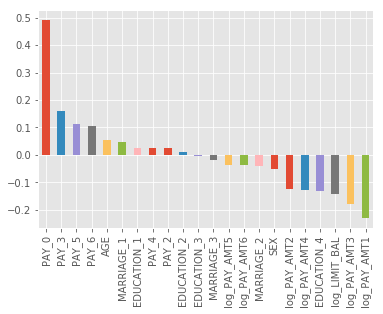

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0],index=dfsub.columns)
weights2 = weights.sort_values(ascending = False)
weights2.plot(kind='bar')
plt.show()

#df_c = df_c.sort_values('Count')

### Logistic Regression:  Interpretation of Weights

- The most important feature in predicting delinquency is how delinquent the most recent payment was.  The more delinquent the payment, the more likely the account is to default.  The second most important feature is the log of the most recent payment amount.  The higher the payment, the less likely the account is to default.  All of this is consistent with intuitive expectations.

- In general, the most important features are the delinquency status of some payments made, the amounts paid and the credit limit.  We are ignoring the Education Level 4, because that is a catch-all category with few values.

We are struck by the preponderance of low weights in this data set.  This could be due to:
- The existence of serial correlation among variables, which include sequential payments and the tendency of customers to be consistent in terms of the delinquency of the payments they make from month to month.  

- We may need to include additional (calculated) variables, such as the number of times delinquent.
- We may need to segment customers into groups, for example light and heavy users of their cards.
- The relationship between certain explanatory variables and the response may not be modeled correctly.  For example, the "Pay" (Delinquency) variables are ordinal, and we are treating them as continuous.  We may need to treat them as categorical.



## APPENDIX:  Description of the Data Set

#### Attribute Information
The data used is "Default of Credit Card Clients" from UCI. It was attained by I-Cheng Yeh with Chung Hua University and Tamkang University in Taiwan. The original goal was to predict default rates.

The data has a 6 month history of 30,000 Taiwanese credit account balances and transactions. Each observation contains a binary reponse variable "default" with values 1 indicating a default occured and 0 indicating no default occured.

The following explanatory variables are included:

 - LIMIT_BAL = Total credit amount allowed
 
 - SEX
     -  1 = Male
     -  2 = Female
 
 - EDUCATION
     - 1 = Graduate School
     - 2 = University
     - 3 = High School
     - 4 = Other
   
 - MARRIAGE
     - 1 = Married
     - 2 = Single
     - 3 = Other
       
 - AGE = Credit holder age in years
 
Payment history (2005)
 - PAY_0 = September
 - PAY_2 = August
 - PAY_3 = July
 - PAY_4 = June
 - PAY_5 = May
 - PAY_6 = April
      -  -1 = payment received on time
      -   1 = payment received one month late
      -   2 = payment received two months late
      -   "......"
      -   9 = payment received nine months late or more
         
Statement amount (NT dollars, 2005)
 - BILL_AMT1 = September
 - BILL_AMT2 = August
 - BILL_AMT3 = July
 - BILL_AMT4 = June
 - BILL_AMT5 = May
 - BILL_AMT6 = April
 
Payment amount (NT dollars, 2005).
 - PAY_AMT1 = September
 - PAY_AMT2 = August
 - PAY_AMT3 = July
 - PAY_AMT4 = June
 - PAY_AMT5 = May
 - PAY_AMT6 = April

Original Source Data Set Information  
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

# Garbage Code Below

In [ ]:
#Create logistic regression object
lr_clf = LogisticRegression(penalty='l2', C=12, class_weight=None)

#Set our iteration count variablew to 0
iter_num=0

#Set our train and test data set variables:
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

#Fit the model, output accuracy and confusion matrices:
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

In [13]:
pd.pivot_table(dfsub,index = ['EDUCATION_4'],values = ["PAY_0"], aggfunc=[len, np.mean, np.median])

,len,mean,median
,PAY_0,PAY_0,PAY_0
EDUCATION_4,,,
0,29532,-0.013172,0
1,468,-0.239316,0
